# Libraries

In [1]:
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import numpy as np
from scipy.stats import ttest_ind
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
import gseapy as gp
from gseapy import barplot, dotplot
from gseapy.plot import gseaplot
from scipy import stats
from scipy.stats import mannwhitneyu
import statsmodels.api as sm
import pickle
from statsmodels.stats.multitest import multipletests
import SIMPApy as sp

# load SOPA results

In [ ]:
rna = sp.load_sopa(r"\Datasets\SOPA - RNAseq - HALLMARK")

In [ ]:
gene = sp.load_sopa(r"\Datasets\SOPA - CNVf - HALLMARK")

In [ ]:
dna = sp.load_sopa(r"\Datasets\SOPA - DNAm - HALLMARK")

# Raw data for single sample insights

In [ ]:
# get raw values for the genes and gene names template
tp = pd.read_csv(r"\Datasets\p2postinteg_tpm_rnaseq_counts.csv", sep=',', index_col=0)
cn = pd.read_csv(r"\Datasets\p2postinteg_cnvs.csv", sep=',', index_col=0)
meth = pd.read_csv(r"\Datasets\p2postinteg_dnam_genes.csv", sep=',', index_col=0)
template = pd.read_csv(r"\Datasets\p2postinteg_genename_ensembleid_template.csv", index_col=0)
# replace tp and cn indices with template gene name based on index
tp.index = template.loc[tp.index].gene_name
cn.index = template.loc[cn.index].gene_name

# Clinical data

In [ ]:
# get clinical data
pop_info = pd.read_csv(r"\Datasets\clin.csv", sep=",", index_col=1)

In [7]:
pop_info[pop_info['key']== 'tm90']

,key,Case ID,project_id,age_at_index,ajcc_pathologic_m,ajcc_pathologic_n,ajcc_pathologic_stage,ajcc_pathologic_t,figo_stage,cancer_type,group,File ID,GFile ID,MFile ID
index,,,,,,,,,,,,,,
175,tm90,TCGA-HV-AA8X,TCGA-PAAD,75.0,MX,N1,Stage IIB,T2,NaN,Pancreas,1.0,44f31ab7-9518-4b29-99fd-9b1247d9d189,d308c5e2-a932-45b9-882d-d838d7ad62e4,7b90ddbd-25fc-4741-92e3-f426dec267e1


# RNA-based SOPA

## Group insights

In [8]:
rnavolc = sp.analyze.group_diffs(rna)

In [9]:
cnvvolc = sp.analyze.group_diffs(gene)

In [10]:
dnavolc = sp.analyze.group_diffs(dna)

In [ ]:
all_results = pd.concat([
    rnavolc, cnvvolc, dnavolc
])

# set fdr threshold
fdr_threshold = 0.05

# Filter for non-significant results
null_distribution_df = all_results[all_results['p_adj'] > fdr_threshold]

# We care about the magnitude of the difference, so we use the absolute values
null_nes_diffs = null_distribution_df['mean_diff'].abs()

# Calculate the 99th percentile of the absolute null differences
nes_threshold = np.percentile(null_nes_diffs, 95)

print(f"Statistically derived NES difference threshold: {nes_threshold:.4f}")
# in the article, this is 0.10 because of ssGSEA and GSVA

Statistically derived NES difference threshold: 0.1122


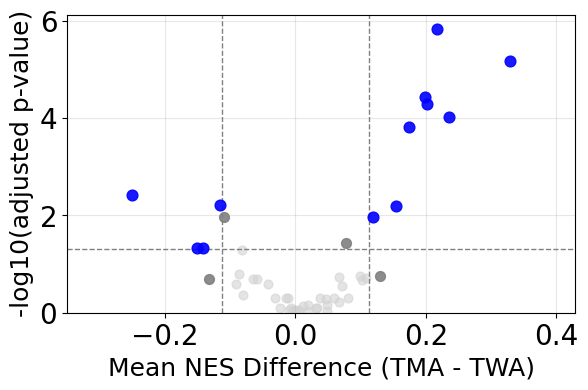

In [ ]:
sp.analyze.plot_volcano(rnavolc, mean_thresh=nes_threshold)

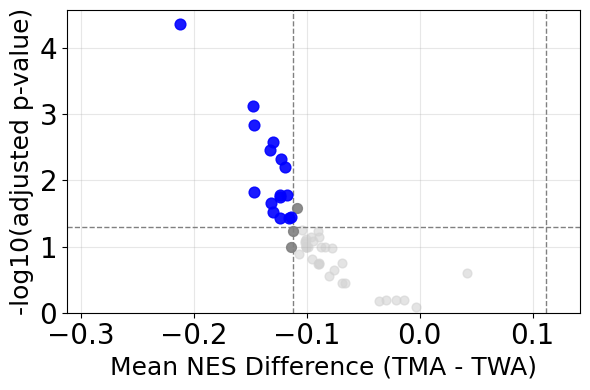

In [ ]:
sp.analyze.plot_volcano(cnvvolc, mean_thresh=nes_threshold)

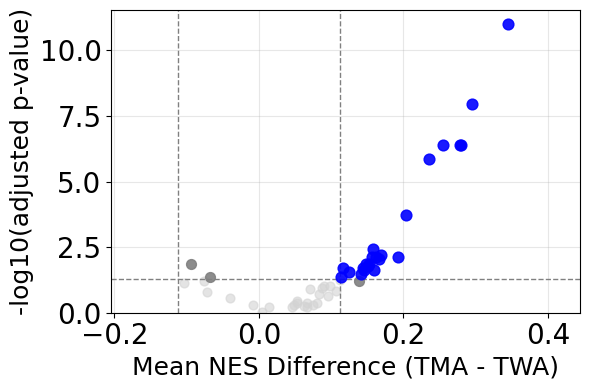

In [ ]:
sp.analyze.plot_volcano(dnavolc, mean_thresh=nes_threshold)

# single sample

In [15]:
# parse rna, gene, and dna dataframes for a matched samples across all omics with fdr<0.05
rna_sig = rna[rna['fdr']<0.05].copy()
gene_sig = gene[gene['fdr']<0.05].copy()
dna_sig = dna[dna['fdr']<0.05].copy()
# get the matched samples
rna_samples = rna_sig['sample_name'].unique()
gene_samples = gene_sig['sample_name'].unique()
dna_samples = dna_sig['sample_name'].unique()
matched_samples = set(rna_samples) & set(gene_samples) & set(dna_samples)

### all samples with fdr<0.05 across all omics

In [16]:
rna_sig[rna_sig['sample_name'].isin(matched_samples)]

,Term,fdr,es,nes,matched_genes,gene %,tag %,lead_genes,sample_name
2400,HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION,0.000000,0.571709,2.408240,COL8A2;ITGB3;COL1A1;COMP;SLIT3;FUCA1;SDC4;EMP3...,8.45%,31/113,COL8A2;ITGB3;COL1A1;COMP;SLIT3;FUCA1;SDC4;EMP3...,tm49
2401,HALLMARK_UNFOLDED_PROTEIN_RESPONSE,0.000000,-0.549141,-2.193407,EIF4A2;SEC11A;EEF2;BAG3;ATP6V0D1;SDAD1;ZBTB17;...,28.80%,34/53,PREB;SRPRB;NOLC1;EIF4A3;DDX10;EXOSC2;CEBPG;HSP...,tm49
2402,HALLMARK_MYC_TARGETS_V2,0.000000,-0.638533,-2.330911,SORD;MAP3K6;WDR74;NOC4L;RRP9;CDK4;PPRC1;SLC29A...,8.83%,20/36,SLC19A1;HSPE1;NOLC1;TMEM97;NOP16;DCTPP1;PLK1;P...,tm49
2403,HALLMARK_MTORC1_SIGNALING,0.000000,-0.468191,-2.136235,PNP;MTHFD2L;ATP6V1D;SORD;IGFBP5;TM7SF2;SEC11A;...,24.54%,61/104,UCHL5;PPIA;HSPE1;CCNF;TMEM97;IDI1;PLK1;TUBG1;B...,tm49
2404,HALLMARK_OXIDATIVE_PHOSPHORYLATION,0.000000,-0.584413,-2.642184,ATP6V1D;MGST3;RETSAT;COX7C;NDUFS8;NDUFC2;POR;S...,23.92%,60/103,FH;MDH2;UQCRH;CYC1;GRPEL1;TIMM17A;CS;IDH2;COX1...,tm49
...,...,...,...,...,...,...,...,...,...
97861,HALLMARK_INFLAMMATORY_RESPONSE,0.004433,-0.344071,-1.739621,ITGB3;PCDH7;ABCA1;IFNAR1;RNF144B;KIF1B;SLC11A2...,28.06%,58/114,NFKBIA;IRF1;RHOG;NMI;P2RX4;IL4R;GNAI3;GPR132;I...,tw869
97862,HALLMARK_CHOLESTEROL_HOMEOSTASIS,0.013138,-0.415062,-1.643452,ANXA5;TNFRSF12A;ALCAM;PMVK;ETHE1;PNRC1;CD9;ATX...,27.60%,19/40,IDI1;ACAT2;TMEM97;S100A11;SQLE;ANTXR2;MVD;PLSC...,tw869
97863,HALLMARK_DNA_REPAIR,0.027599,-0.340280,-1.553383,RRM2B;RNMT;TK2;RPA2;REV3L;POLR2A;GTF2F1;DDB1;E...,16.88%,29/77,POLE4;SAC3D1;POLR2G;RBX1;RALA;POLA2;AAAS;POLR2...,tw869
97864,HALLMARK_PROTEIN_SECRETION,0.030653,0.561877,1.774768,VAMP4;IGF2R;ABCA1;STX12;SNX2;GOLGA4;GBF1;AP3B1...,12.66%,18/46,VAMP4;IGF2R;ABCA1;STX12;SNX2;GOLGA4;GBF1;AP3B1...,tw869


In [17]:
gene_sig[gene_sig['sample_name'].isin(matched_samples)]

,Term,fdr,es,nes,matched_genes,gene %,tag %,lead_genes,sample_name
2400,HALLMARK_HEDGEHOG_SIGNALING,0.036778,0.343130,1.754971,DPYSL2;CELSR1;MYH9;SLIT1;CRMP1;LDB1;UNC5C;THY1...,54.80%,16/17,DPYSL2;CELSR1;MYH9;SLIT1;CRMP1;LDB1;UNC5C;THY1...,tm49
2850,HALLMARK_HEDGEHOG_SIGNALING,0.036778,0.343130,1.754971,DPYSL2;CELSR1;MYH9;SLIT1;CRMP1;LDB1;UNC5C;THY1...,54.80%,16/17,DPYSL2;CELSR1;MYH9;SLIT1;CRMP1;LDB1;UNC5C;THY1...,tm58
3000,HALLMARK_HEDGEHOG_SIGNALING,0.036778,0.343130,1.754971,DPYSL2;CELSR1;MYH9;SLIT1;CRMP1;LDB1;UNC5C;THY1...,54.80%,16/17,DPYSL2;CELSR1;MYH9;SLIT1;CRMP1;LDB1;UNC5C;THY1...,tm61
3600,HALLMARK_HEDGEHOG_SIGNALING,0.015091,0.563589,1.721794,TLE1;CELSR1;UNC5C;MYH9;NKX6-1;DPYSL2;CRMP1;HEY...,31.12%,12/17,TLE1;CELSR1;UNC5C;MYH9;NKX6-1;DPYSL2;CRMP1;HEY...,tm73
4350,HALLMARK_HEDGEHOG_SIGNALING,0.036778,0.343130,1.754971,DPYSL2;CELSR1;MYH9;SLIT1;CRMP1;LDB1;UNC5C;THY1...,54.80%,16/17,DPYSL2;CELSR1;MYH9;SLIT1;CRMP1;LDB1;UNC5C;THY1...,tm88
...,...,...,...,...,...,...,...,...,...
95500,HALLMARK_HEDGEHOG_SIGNALING,0.036778,0.343130,1.754971,DPYSL2;CELSR1;MYH9;SLIT1;CRMP1;LDB1;UNC5C;THY1...,54.80%,16/17,DPYSL2;CELSR1;MYH9;SLIT1;CRMP1;LDB1;UNC5C;THY1...,tw822
96000,HALLMARK_HEDGEHOG_SIGNALING,0.030664,0.343240,1.794515,DPYSL2;CELSR1;MYH9;SLIT1;CRMP1;LDB1;UNC5C;THY1...,54.79%,16/17,DPYSL2;CELSR1;MYH9;SLIT1;CRMP1;LDB1;UNC5C;THY1...,tw832
96450,HALLMARK_HEDGEHOG_SIGNALING,0.022843,0.372939,1.801040,DPYSL2;CELSR1;MYH9;SLIT1;CRMP1;LDB1;UNC5C;THY1...,51.83%,16/17,DPYSL2;CELSR1;MYH9;SLIT1;CRMP1;LDB1;UNC5C;THY1...,tw841
97600,HALLMARK_HEDGEHOG_SIGNALING,0.036778,0.343130,1.754971,DPYSL2;CELSR1;MYH9;SLIT1;CRMP1;LDB1;UNC5C;THY1...,54.80%,16/17,DPYSL2;CELSR1;MYH9;SLIT1;CRMP1;LDB1;UNC5C;THY1...,tw864


In [18]:
dna_sig[dna_sig['sample_name'].isin(matched_samples)]

,Term,fdr,es,nes,matched_genes,gene %,tag %,lead_genes,sample_name
2400,HALLMARK_MYC_TARGETS_V1,0.003765,0.442063,1.872459,SNRPA1;CYC1;DDX21;RSL1D1;ETF1;EIF3J;COX5A;PSMA...,16.36%,35/100,SNRPA1;CYC1;DDX21;RSL1D1;ETF1;EIF3J;COX5A;PSMA...,tm49
2401,HALLMARK_E2F_TARGETS,0.005020,0.447925,1.880567,ATAD2;DSCC1;BUB1B;DCTPP1;NAA38;HUS1;POLA2;RPA2...,30.18%,50/97,ATAD2;DSCC1;BUB1B;DCTPP1;NAA38;HUS1;POLA2;RPA2...,tm49
2402,HALLMARK_OXIDATIVE_PHOSPHORYLATION,0.008785,0.441923,1.883636,TOMM22;UQCRC2;IDH3A;UQCRB;NDUFC1;CYC1;COX5A;MR...,26.92%,44/103,TOMM22;UQCRC2;IDH3A;UQCRB;NDUFC1;CYC1;COX5A;MR...,tm49
2403,HALLMARK_MTORC1_SIGNALING,0.011922,0.413915,1.761780,IDI1;UFM1;ARPC5L;TMEM97;ETF1;SLC9A3R1;GPI;PPIA...,12.82%,23/104,IDI1;UFM1;ARPC5L;TMEM97;ETF1;SLC9A3R1;GPI;PPIA...,tm49
2404,HALLMARK_MYC_TARGETS_V2,0.044175,0.466430,1.653483,DCTPP1;TMEM97;HSPE1;PES1;PLK1;FARSA;MYC;NDUFAF...,27.41%,18/36,DCTPP1;TMEM97;HSPE1;PES1;PLK1;FARSA;MYC;NDUFAF...,tm49
...,...,...,...,...,...,...,...,...,...
96000,HALLMARK_MYC_TARGETS_V2,0.027623,0.467949,1.775823,DCTPP1;HSPE1;NDUFAF4;SRM;DUSP2;IMP4;PLK4;PPRC1...,34.82%,20/36,DCTPP1;HSPE1;NDUFAF4;SRM;DUSP2;IMP4;PLK4;PPRC1...,tw832
96450,HALLMARK_OXIDATIVE_PHOSPHORYLATION,0.009779,0.429162,1.902969,NDUFA4;COX17;ATP6V1G1;COX10;CYC1;UQCRC2;NDUFV2...,15.12%,31/103,NDUFA4;COX17;ATP6V1G1;COX10;CYC1;UQCRC2;NDUFV2...,tw841
97600,HALLMARK_REACTIVE_OXYGEN_SPECIES_PATHWAY,0.010982,-0.527531,-2.000167,NDUFA6;SOD1;MPO;PFKP;GCLC;TXNRD2;STK25;ATOX1;G...,21.36%,13/22,HHEX;OXSR1;GCLM;LSP1;PDLIM1;PRDX6;TXNRD1;SBNO2...,tw864
97601,HALLMARK_ALLOGRAFT_REJECTION,0.025770,0.382017,1.813573,CCL11;PF4;TRAT1;HLA-DRA;ICAM1;HLA-DOA;HLA-A;RP...,29.23%,59/115,CCL11;PF4;TRAT1;HLA-DRA;ICAM1;HLA-DOA;HLA-A;RP...,tw864


### tm90

Assuming we would want to assess tm90. Now naturally, if we only want to compare it to pancreatic cancer patients, we would have to extract ranking metrics for all pancreatic cases vs pancreatic controls.

However, for the sake of conciseness, we would immediately proceed with analyses just to show what insights we could potentially extract.

In [19]:
# create list of matched genes and tag%
rna_sig['matched_genes_list'] = rna_sig['matched_genes'].str.split(';')
rna_sig['tag %_list'] = rna_sig['tag %'].str.split(';')
gene_sig['matched_genes_list'] = gene_sig['matched_genes'].str.split(';')
gene_sig['tag %_list'] = gene_sig['tag %'].str.split(';')
dna_sig['matched_genes_list'] = dna_sig['matched_genes'].str.split(';')
dna_sig['tag %_list'] = dna_sig['tag %'].str.split(';')
# get the tm90 sample
tm90rna = rna_sig[rna_sig['sample_name'] == 'tm90'].copy()
tm90gene = gene_sig[gene_sig['sample_name'] == 'tm90'].copy()
tm90dna = dna_sig[dna_sig['sample_name'] == 'tm90'].copy()
# add ['omic'] column to each dataframe
tm90rna['Omic'] = 'RNAseq'
tm90gene['Omic'] = 'CNV'
tm90dna['Omic'] = 'DNAm'
# merge the dataframes
tm90 = pd.concat([tm90rna, tm90gene, tm90dna])

In [20]:
pop_info[pop_info['key']== 'tm90']

,key,Case ID,project_id,age_at_index,ajcc_pathologic_m,ajcc_pathologic_n,ajcc_pathologic_stage,ajcc_pathologic_t,figo_stage,cancer_type,group,File ID,GFile ID,MFile ID
index,,,,,,,,,,,,,,
175,tm90,TCGA-HV-AA8X,TCGA-PAAD,75.0,MX,N1,Stage IIB,T2,NaN,Pancreas,1.0,44f31ab7-9518-4b29-99fd-9b1247d9d189,d308c5e2-a932-45b9-882d-d838d7ad62e4,7b90ddbd-25fc-4741-92e3-f426dec267e1


In [21]:
tm90

,Term,fdr,es,nes,matched_genes,gene %,tag %,lead_genes,sample_name,matched_genes_list,tag %_list,Omic
4450,HALLMARK_INTERFERON_ALPHA_RESPONSE,0.008546,0.698115,2.215306,CMPK2;SAMD9;DDX60;NMI;LGALS3BP;PLSCR1;RTP4;IL7...,11.97%,24/51,CMPK2;SAMD9;DDX60;NMI;LGALS3BP;PLSCR1;RTP4;IL7...,tm90,"[CMPK2, SAMD9, DDX60, NMI, LGALS3BP, PLSCR1, R...",[24/51],RNAseq
4451,HALLMARK_PI3K_AKT_MTOR_SIGNALING,0.010740,-0.459401,-1.770134,RPS6KA1;PIN1;DUSP3;CAMK4;DAPP1;ARHGDIA;NCK1;RA...,13.79%,18/52,UBE2N;ATF1;RAF1;PTPN11;RIPK1;PRKAR2A;PLA2G12A;...,tm90,"[RPS6KA1, PIN1, DUSP3, CAMK4, DAPP1, ARHGDIA, ...",[18/52],RNAseq
4452,HALLMARK_MYC_TARGETS_V2,0.016111,-0.495132,-1.780800,SLC29A2;MAP3K6;FARSA;TMEM97;GRWD1;HSPE1;HK2;PE...,26.93%,18/36,PA2G4;RCL1;NOC4L;UTP20;CDK4;SRM;RRP9;PPRC1;WDR...,tm90,"[SLC29A2, MAP3K6, FARSA, TMEM97, GRWD1, HSPE1,...",[18/36],RNAseq
4453,HALLMARK_MYC_TARGETS_V1,0.016111,-0.416306,-1.842422,PSMB3;MRPL23;VDAC1;PSMD1;FAM120A;PSMD14;SNRPD1...,38.52%,66/100,PA2G4;PWP1;PTGES3;EXOSC7;RPL22;RPS6;SMARCC1;PA...,tm90,"[PSMB3, MRPL23, VDAC1, PSMD1, FAM120A, PSMD14,...",[66/100],RNAseq
4450,HALLMARK_HEDGEHOG_SIGNALING,0.002453,0.485065,1.987419,CDK5R1;CRMP1;SCG2;DPYSL2;CELSR1;MYH9;SLIT1;LDB...,0.37%,3/17,CDK5R1;CRMP1;SCG2,tm90,"[CDK5R1, CRMP1, SCG2, DPYSL2, CELSR1, MYH9, SL...",[3/17],CNV
4450,HALLMARK_UV_RESPONSE_DN,0.000000,-0.476046,-2.052864,PRKAR2B;CDKN1B;COL5A2;MAP1B;ITGB3;DLC1;SLC7A1;...,13.53%,21/67,NEK7;RUNX1;LAMC1;COL1A1;NFIB;MT1E;MYC;F3;ANXA4...,tm90,"[PRKAR2B, CDKN1B, COL5A2, MAP1B, ITGB3, DLC1, ...",[21/67],DNAm
4451,HALLMARK_PANCREAS_BETA_CELLS,0.012182,0.589040,1.811813,ISL1;PCSK1;SCGN;SST;NEUROG3;CHGA;PCSK2;NKX2-2;...,15.05%,12/23,ISL1;PCSK1;SCGN;SST;NEUROG3;CHGA;PCSK2;NKX2-2;...,tm90,"[ISL1, PCSK1, SCGN, SST, NEUROG3, CHGA, PCSK2,...",[12/23],DNAm
4452,HALLMARK_TGF_BETA_SIGNALING,0.023365,-0.537051,-1.809546,THBS1;RAB31;CDK9;ID3;HDAC1;TGFB1;CDH1;LEFTY2;B...,20.52%,9/24,PPP1R15A;BMPR2;SMURF2;SMAD7;SMAD3;BMP2;SLC20A1...,tm90,"[THBS1, RAB31, CDK9, ID3, HDAC1, TGFB1, CDH1, ...",[9/24],DNAm


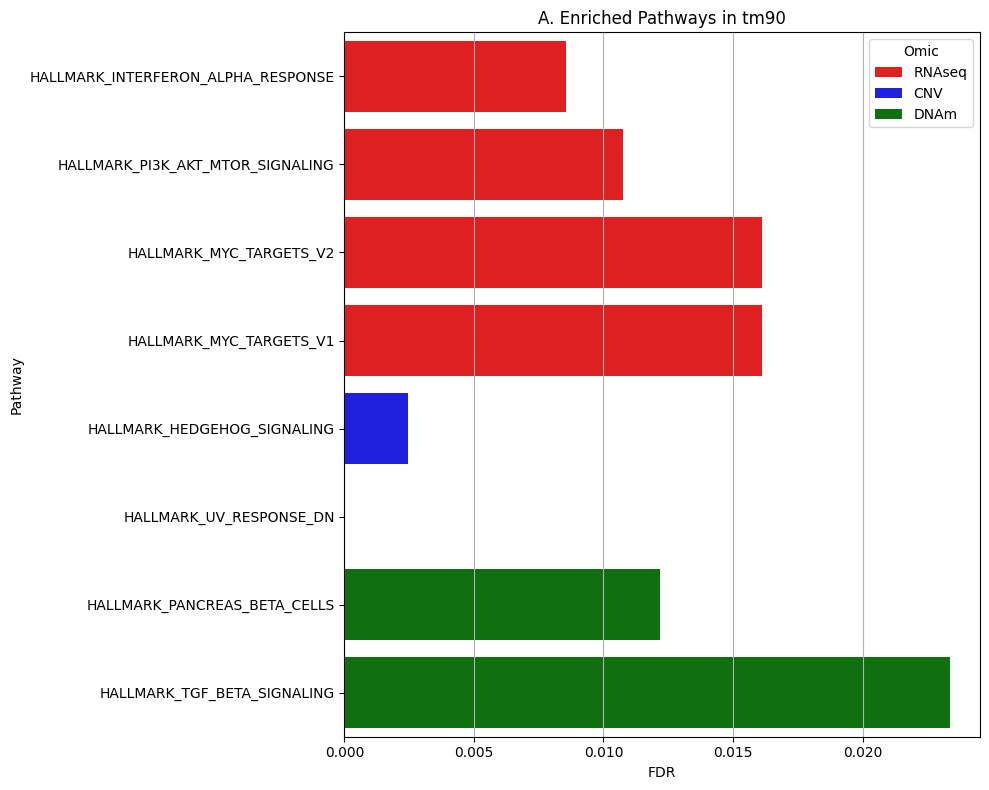

In [22]:
# bar plot tm90, y-axis is pathway, x-axis is fdr
plt.figure(figsize=(10, 8))
sns.barplot(data=tm90, x='fdr', y='Term', hue='Omic', palette={'RNAseq': 'red', 'CNV': 'blue', 'DNAm': 'green'})
plt.title("A. Enriched Pathways in tm90")
plt.xlabel("FDR")
plt.ylabel("Pathway")
plt.grid(True,axis='x')
plt.tight_layout()
plt.show()

## RNA

In [24]:
tm90rna

,Term,fdr,es,nes,matched_genes,gene %,tag %,lead_genes,sample_name,matched_genes_list,tag %_list,Omic
4450,HALLMARK_INTERFERON_ALPHA_RESPONSE,0.008546,0.698115,2.215306,CMPK2;SAMD9;DDX60;NMI;LGALS3BP;PLSCR1;RTP4;IL7...,11.97%,24/51,CMPK2;SAMD9;DDX60;NMI;LGALS3BP;PLSCR1;RTP4;IL7...,tm90,"[CMPK2, SAMD9, DDX60, NMI, LGALS3BP, PLSCR1, R...",[24/51],RNAseq
4451,HALLMARK_PI3K_AKT_MTOR_SIGNALING,0.010740,-0.459401,-1.770134,RPS6KA1;PIN1;DUSP3;CAMK4;DAPP1;ARHGDIA;NCK1;RA...,13.79%,18/52,UBE2N;ATF1;RAF1;PTPN11;RIPK1;PRKAR2A;PLA2G12A;...,tm90,"[RPS6KA1, PIN1, DUSP3, CAMK4, DAPP1, ARHGDIA, ...",[18/52],RNAseq
4452,HALLMARK_MYC_TARGETS_V2,0.016111,-0.495132,-1.780800,SLC29A2;MAP3K6;FARSA;TMEM97;GRWD1;HSPE1;HK2;PE...,26.93%,18/36,PA2G4;RCL1;NOC4L;UTP20;CDK4;SRM;RRP9;PPRC1;WDR...,tm90,"[SLC29A2, MAP3K6, FARSA, TMEM97, GRWD1, HSPE1,...",[18/36],RNAseq
4453,HALLMARK_MYC_TARGETS_V1,0.016111,-0.416306,-1.842422,PSMB3;MRPL23;VDAC1;PSMD1;FAM120A;PSMD14;SNRPD1...,38.52%,66/100,PA2G4;PWP1;PTGES3;EXOSC7;RPL22;RPS6;SMARCC1;PA...,tm90,"[PSMB3, MRPL23, VDAC1, PSMD1, FAM120A, PSMD14,...",[66/100],RNAseq


In [25]:
# filter tp to include only genes in the matched_genes_list (in the paper the genes are leading edge genes)
tp90 = tp.loc[tm90rna.loc[tm90rna['Term'] == 'HALLMARK_INTERFERON_ALPHA_RESPONSE']['matched_genes_list'].explode().unique()]
# remove tm samples from tp but keep tw samples except for tm90 (avoid tm900)
tp90 = tp90.drop(columns=tp90.columns[tp.columns.str.contains('tm') & ~tp90.columns.str.endswith('tm90')])

In [26]:
# filter cn to include only genes in the matched_genes_list
cn90 = cn.loc[tm90gene.loc[tm90gene['Term'] == 'HALLMARK_HEDGEHOG_SIGNALING']['matched_genes_list'].explode().unique()]
# remove tm samples from tp but keep tw samples except for tm90 (avoid tm900)
cn90 = cn90.drop(columns=cn90.columns[cn.columns.str.contains('tm') & ~cn90.columns.str.endswith('tm90')])

In [27]:
# filter meth to include only genes in the matched_genes_list
meth90 = meth.loc[tm90dna.loc[tm90dna['Term'] == 'HALLMARK_UV_RESPONSE_DN']['matched_genes_list'].explode().unique()]
# remove tm samples from tp but keep tw samples except for tm90 (avoid tm900)
meth90 = meth90.drop(columns=meth90.columns[meth.columns.str.contains('tm') & ~meth90.columns.str.endswith('tm90')])

In [28]:
# get tw sample keys from pop_info as list if key starts with tw and cancer_type is pancreas
tw_pancreas = list(pop_info[(pop_info['cancer_type']== 'Pancreas') & (pop_info['key'].str.startswith('tw'))]['key'])

## Visuals

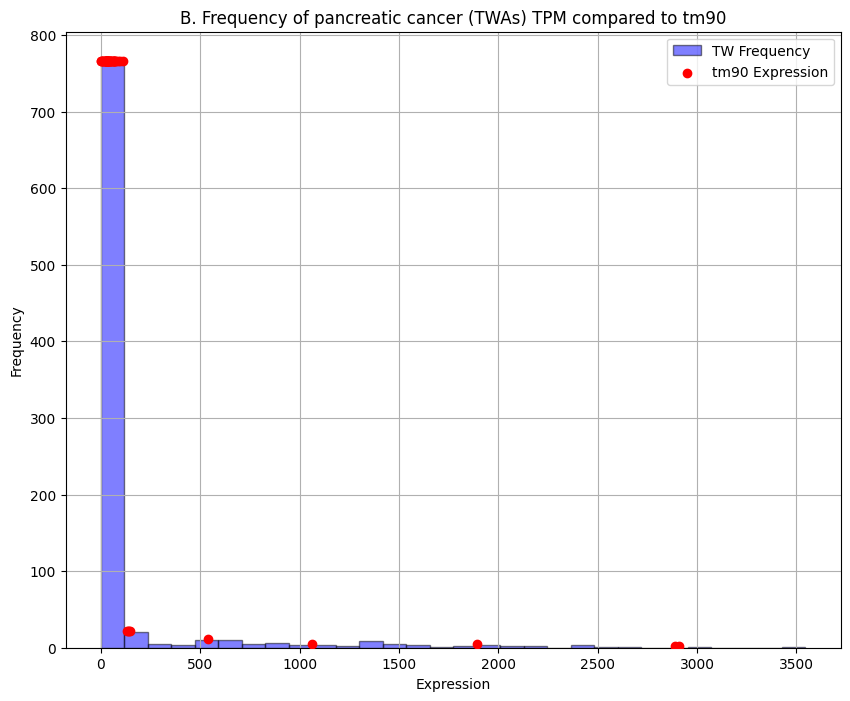

In [ ]:
# Aggregate all tw values into one array
tw_values = tp90[tw_pancreas].values.flatten()

plt.figure(figsize=(10, 8))
# Plot histogram for TW values showing frequency counts
counts, bins, _ = plt.hist(tw_values, bins=30, color='blue', alpha=0.5, edgecolor='black', label='TW Frequency')

# Get tm90 expression values
tm90_values = tp90['tm90'].values
# Determine which bin each tm90 value falls into (adjust indices to match count array)
bin_indices = np.digitize(tm90_values, bins) - 1
bin_indices = np.clip(bin_indices, 0, len(counts) - 1)
tm90_freqs = counts[bin_indices]


# Overlay tm90 points; add a small offset so points sit above the histogram bars
offset = 2  # adjust offset if needed
plt.scatter(tm90_values, tm90_freqs + offset, color="red", zorder=10, label='tm90 Expression')

plt.xlabel('Expression')
plt.ylabel('Frequency')
plt.title('B. Frequency of pancreatic cancer (TWAs) TPM compared to tm90')
plt.grid(True)
plt.legend()
plt.show()

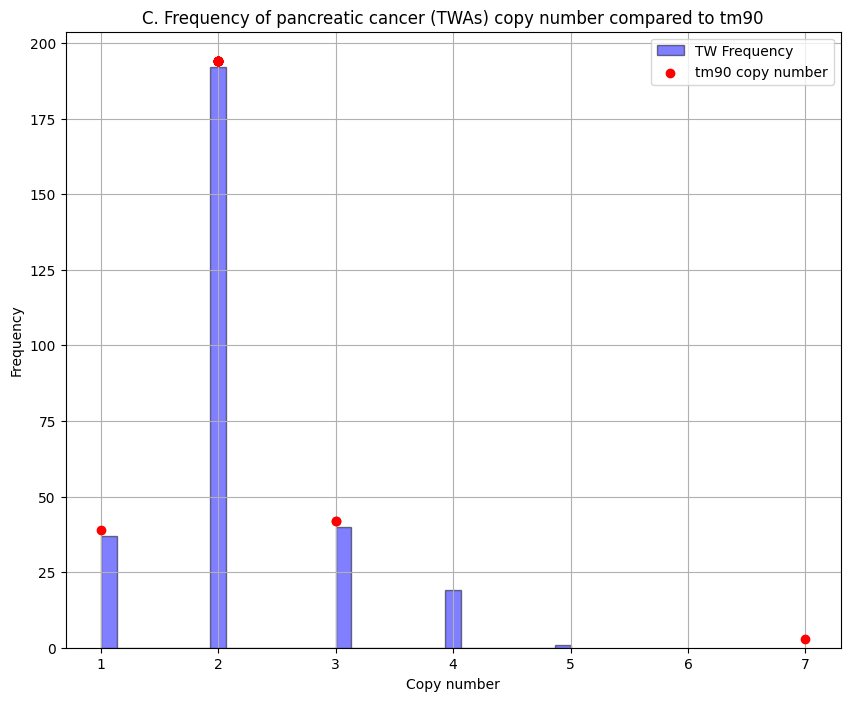

In [ ]:
# Aggregate all tw values into one array
tw_values = cn90[tw_pancreas].values.flatten()

plt.figure(figsize=(10, 8))
# Plot histogram for TW values showing frequency counts
counts, bins, _ = plt.hist(tw_values, bins=30, color='blue', alpha=0.5, edgecolor='black', label='TW Frequency')

# Get tm90 expression values
tm90_values = cn90['tm90'].values
# Determine which bin each tm90 value falls into (adjust indices to match count array)
bin_indices = np.digitize(tm90_values, bins) - 1
bin_indices = np.clip(bin_indices, 0, len(counts) - 1)
tm90_freqs = counts[bin_indices]


# Overlay tm90 points; add a small offset so points sit above the histogram bars
offset = 2  # adjust offset if needed
plt.scatter(tm90_values, tm90_freqs + offset, color="red", zorder=10, label='tm90 copy number')

plt.xlabel('Copy number')
plt.ylabel('Frequency')
plt.title('C. Frequency of pancreatic cancer (TWAs) copy number compared to tm90')
plt.grid(True)
plt.legend()
plt.show()

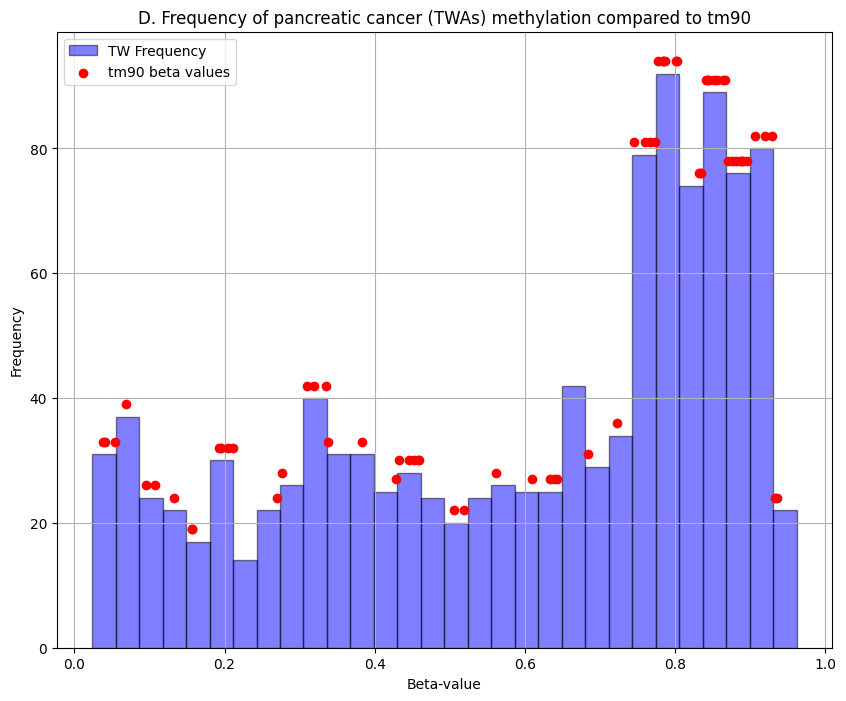

In [ ]:
# Aggregate all tw values into one array
tw_values = meth90[tw_pancreas].values.flatten()

plt.figure(figsize=(10, 8))
# Plot histogram for TW values showing frequency counts
counts, bins, _ = plt.hist(tw_values, bins=30, color='blue', alpha=0.5, edgecolor='black', label='TW Frequency')

# Get tm90 expression values
tm90_values = meth90['tm90'].values
# Determine which bin each tm90 value falls into (adjust indices to match count array)
bin_indices = np.digitize(tm90_values, bins) - 1
bin_indices = np.clip(bin_indices, 0, len(counts) - 1)
tm90_freqs = counts[bin_indices]

# Overlay tm90 points; add a small offset so points sit above the histogram bars
offset = 2  # adjust offset if needed
plt.scatter(tm90_values, tm90_freqs + offset, color="red", zorder=10, label='tm90 beta values')

plt.xlabel('Beta-value')
plt.ylabel('Frequency')
plt.title('D. Frequency of pancreatic cancer (TWAs) methylation compared to tm90')
plt.grid(True)
plt.legend()
plt.show()

Thus, we can see that the SOPA tool allows us to see which genes enriching a specific pathway in a sample compare to the genes of the entirety of the control population. 

For example, these insights could be tested with therapies targeting specific genes, to understand the impact of a specific treatment on a single sample compared to its control state for a specific pathway or genes enriching a specific pathway.